Install libraries

In [30]:
!pip3 install librosa tensorflow matplotlib


Defaulting to user installation because normal site-packages is not writeable


Import Libraries

In [4]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


Load and Preprocess Audio Files

In [5]:

def preprocess_audio(file_path, n_mels=128, n_fft=2048, hop_length=512, duration=5):
    # Load the audio file
    y, sr = librosa.load(file_path, duration=duration)
    
    # Generate mel spectrogram using the correct syntax for your librosa version
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    
    # Convert to log scale (dB)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    
    # Resize to fixed size (e.g., 128x128) for input to the model
    if log_spectrogram.shape[1] < 128:
        log_spectrogram = np.pad(log_spectrogram, ((0, 0), (0, 128 - log_spectrogram.shape[1])), mode='constant')
    else:
        log_spectrogram = log_spectrogram[:, :128]
    
    return log_spectrogram


Load and process all audio files in both classes

In [6]:
data_dir = 'data'  # Replace with actual path
categories = ['elephants', 'non_elephants']
data = []
labels = []

for label, category in enumerate(categories):
    folder_path = os.path.join(data_dir, category)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        spectrogram = preprocess_audio(file_path)
        data.append(spectrogram)
        labels.append(label)

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)


Reshape data for the CNN model and convert labels to categorical format.

In [8]:
# Reshape for CNN input (e.g., 128x128 images with a single channel)
data = data[..., np.newaxis]

# One-hot encode labels
labels = to_categorical(labels, num_classes=2)


Split Data into Training and Testing Sets

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


Building the CNN Model

In [36]:


# Define the CNN model
model = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),  # Adjust input shape to match data dimensions
    MaxPooling2D((2, 2)),
    
    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Flatten the output and add dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    
    # Output layer (2 classes for elephant vs non-elephant)
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,312,450 (12.64 MB)

 Trainable params: 3,312,450 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

Training the Model

In [37]:
# Define the number of epochs and batch size
epochs = 500
batch_size = 32

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)


Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - accuracy: 0.5930 - loss: 7.2610 - val_accuracy: 0.7000 - val_loss: 2.2971
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.5594 - loss: 4.1238 - val_accuracy: 0.4000 - val_loss: 0.8247
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.5898 - loss: 0.6715 - val_accuracy: 0.8000 - val_loss: 0.5512
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6547 - loss: 0.6696 - val_accuracy: 0.4000 - val_loss: 0.6165
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.7195 - loss: 0.5031 - val_accuracy: 0.7000 - val_loss: 0.5689
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7086 - loss: 0.5129 - val_accuracy: 0.6500 - val_loss: 0.5507
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7797 - loss: 0.4923 - val_accuracy: 0.8000 - val_loss: 0.4454
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7844 - loss: 0.4681 - val_accuracy: 0.8000 - v

Evaluating the Model

In [39]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8000 - loss: 1.3672
Test Loss: 1.3672
Test Accuracy: 0.8000


Plot Training History

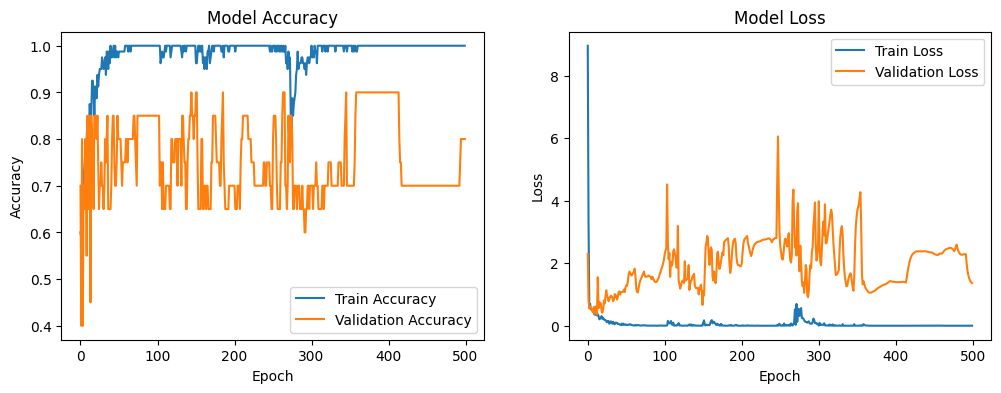

In [40]:


# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


Saving the Model

In [41]:
# Save the model
model.save('elephant_sound_classifier.keras')
print("Model saved successfully.")


Model saved successfully.


Loading the Model 

In [9]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('elephant_sound_classifier.keras')
print("Model loaded successfully.")


Model loaded successfully.


Define a function to load, preprocess, and predict on the new audio file.

In [2]:
def predict_sound(model, file_path):
    # Preprocess the audio file
    spectrogram = preprocess_audio(file_path)
    
    # Reshape to match the input shape (128x128x1)
    spectrogram = spectrogram[..., np.newaxis]
    spectrogram = np.expand_dims(spectrogram, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(spectrogram)
    class_idx = np.argmax(prediction)  # Get the index of the highest probability
    
    # Map the index to the class label
    labels = ['elephant', 'non_elephant']
    predicted_label = labels[class_idx]
    confidence = prediction[0][class_idx]
    
    print(f"Predicted: {predicted_label} with confidence {confidence:.4f}")





Run the prediction on a test file.

In [10]:
predict_sound(model, 'test\Bear_6.wav')
predict_sound(model, 'test\Cow_4.wav')
predict_sound(model, 'test\Elephant_9.wav')
predict_sound(model, 'test\Frog_9.wav')
predict_sound(model, 'test\Sheep_5.wav')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Predicted: non_elephant with confidence 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted: non_elephant with confidence 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted: elephant with confidence 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted: non_elephant with confidence 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted: non_elephant with confidence 1.0000


Testing with microphone

In [11]:
import tensorflow as tf
import librosa
import numpy as np
import sounddevice as sd
from scipy.ndimage import gaussian_filter1d

# Step 1: Load the pre-trained model
model = tf.keras.models.load_model('elephant_sound_classifier.keras')

# Check the input shape expected by the model
input_shape = model.input_shape
print(f"Model expected input shape: {input_shape}")

# Step 2: Record audio from the microphone
def record_audio(duration=3, sr=22050):
    """
    Records audio for a specified duration using the default microphone.
    """
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1)
    sd.wait()  # Wait until recording is finished
    print("Recording complete.")
    return audio.flatten()

# Step 3: Preprocess the recorded audio
def preprocess_audio(audio, sr=22050, target_shape=(128, 128)):
    """
    Converts recorded audio to a mel spectrogram, normalizes it,
    and reshapes it to fit the model's expected input shape.
    """
    # Apply a Gaussian filter to smooth the audio signal
    audio = gaussian_filter1d(audio, sigma=1)
    
    # Generate Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=sr//2)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Normalize the spectrogram
    mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    
    # Pad or truncate to the target shape (128, 128)
    if mel_spec_db.shape[1] < target_shape[1]:
        pad_width = target_shape[1] - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :target_shape[1]]
    
    # Ensure the final shape is (128, 128, 1)
    mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Add channel dimension: (128, 128, 1)
    mel_spec_db = np.expand_dims(mel_spec_db, axis=0)   # Add batch dimension: (1, 128, 128, 1)
    return mel_spec_db

# Step 4: Predict using the pre-trained model with confidence threshold
def predict_audio(audio, sr=22050, threshold=0.6):
    """
    Predicts whether the recorded audio is an elephant sound or not.
    Returns the confidence score along with the label.
    """
    processed_audio = preprocess_audio(audio, sr)
    prediction = model.predict(processed_audio)
    
    confidence = prediction[0][0]  # Extract the confidence score for "Elephant"
    print(f"Confidence Score: {confidence:.4f}")
    
    if confidence > threshold:
        return "Elephant"
    else:
        return "Not Elephant"

# Step 5: Main function to record audio and classify
if __name__ == "__main__":
    # Record audio for 10 seconds
    recorded_audio = record_audio(duration=10)
    
    # Predict if the recorded sound is an elephant sound with a tunable threshold
    threshold = 0.5
    prediction = predict_audio(recorded_audio, threshold=threshold)
    print(f"Prediction: {prediction}")


Model expected input shape: (None, 128, 128, 1)
Recording...
Recording complete.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Confidence Score: 0.2171
Prediction: Not Elephant
